In [138]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from tqdm import tqdm
import pandas as pd
import os
import seaborn as sns

(512, 768, 3)


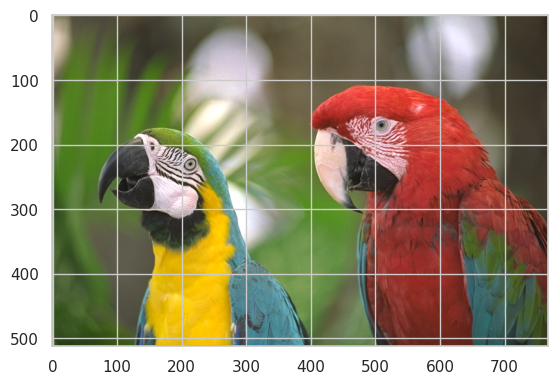

In [139]:
root = "images"

img = cv2.imread(f"{root}/kodim23.png") #Available : kodim01.png, kodim02.png, kodim05.png, kodim13.png, kodim23.png
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)
plt.imshow(img)
plt.show()

In [140]:
def get_size(img):
    h, w, c = img.shape

    #size of each channel
    sizes = [ np.ceil( np.log2(len( np.unique(img[:,:,i]) )))*h*w  for i in range(c) ]
    
    return sum(sizes)

def kl_transform(img):

    h, w, c = img.shape

    means = np.mean(img, axis=(0, 1))

    tmp_img = img - means

    tmp_img = tmp_img.reshape(-1, c) 

    cov_matrix = np.dot(tmp_img.T, tmp_img) / (h*w)

    eig_values, eig_vectors = np.linalg.eig(cov_matrix)

    idx = eig_values.argsort()[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]

    eig_vectors = eig_vectors.T 

    kl_transformed = np.dot(tmp_img, eig_vectors.T)

    kl_transformed = kl_transformed.reshape(img.shape)

    compressed_size = get_size(kl_transformed)

    return kl_transformed, eig_vectors, eig_values, means




def inverse_kl_transform(kl_transformed, eig_vectors, means):

    eig_vectors_inv = np.linalg.pinv(eig_vectors)

    kl_transformed_reshaped = kl_transformed.reshape(-1, kl_transformed.shape[2])

    img_back_to_original_basis = np.dot(kl_transformed_reshaped, eig_vectors_inv.T)

    img_back_to_original_shape = img_back_to_original_basis.reshape(kl_transformed.shape)

    reconstructed_img = img_back_to_original_shape + means

    return reconstructed_img



def quantify(img, quantify_strategy = [8,8,2]) :

    zero_quantify = quantify_strategy == 0
    quantify_strategy = np.maximum(quantify_strategy, 1)

    max_values, mini_values = np.max(img, axis=(0,1)), np.min(img, axis=(0,1))

    nb_steps = 2**np.array(quantify_strategy) - 1
    step_size = (max_values - mini_values) / nb_steps

    img_reshaped = img.reshape(-1, img.shape[2])
    quantized_img = np.round((img_reshaped - mini_values)/step_size) * step_size + mini_values

    quantized_img = quantized_img.reshape(img.shape)

    quantized_img[zero_quantify] = np.reshape( np.mean(img, axis=(0,1)) , (1,1,3))[zero_quantify]

    return quantized_img



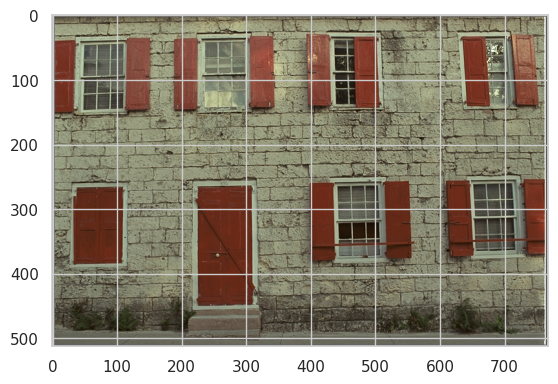

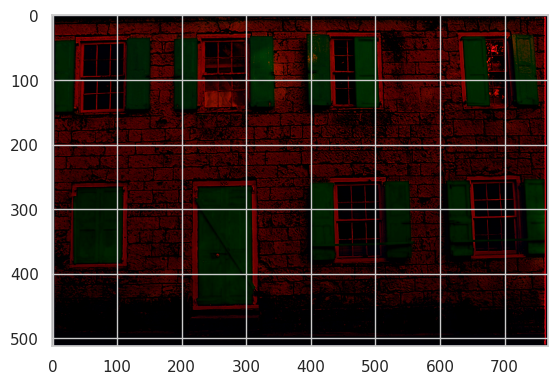

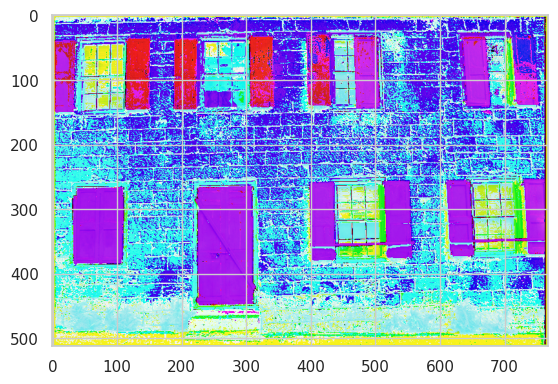

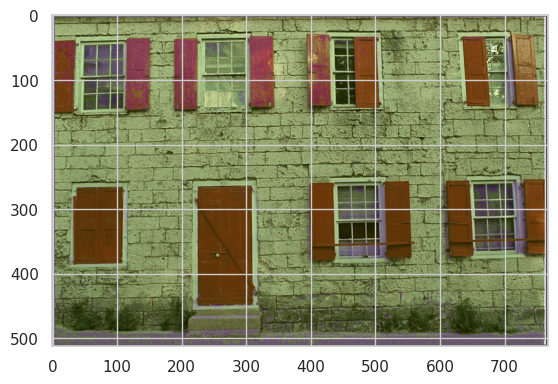

In [141]:
root = "images"

img = cv2.imread(f"{root}/kodim01.png") #Available : kodim01.png, kodim02.png, kodim05.png, kodim13.png, kodim23.png
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

kl_transformed, eig_vectors, eig_values, means = kl_transform(img)
plt.imshow(np.clip(kl_transformed, 0, 255).astype(np.uint8))
plt.show()

quantized_img = quantify(kl_transformed, [8,8,0])
plt.imshow(np.clip(quantized_img.astype(np.uint8), 0, 255))
plt.show()

inverse_kl_transformed = inverse_kl_transform(quantized_img, eig_vectors, means)
inverse_kl_transformed = np.clip(inverse_kl_transformed, 0, 255).astype(np.uint8)
plt.imshow(inverse_kl_transformed)
plt.show()

In [142]:
print("==== PSNR (Original, Inverse KL) ====")
psnr_score = psnr(img, inv_kl_img)
print(psnr_score)


print("\n==== SSIM (Original, Inverse KL) ====")
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
inv_kl_img_gray = cv2.cvtColor(inv_kl_img, cv2.COLOR_RGB2GRAY)
ssim_score = ssim(img_gray, inv_kl_img_gray)
print(ssim_score)

==== PSNR (Original, Inverse KL) ====
11.795145281578316

==== SSIM (Original, Inverse KL) ====
0.18060957899757843


In [143]:
def compression_rate(original, compressed):
    _, original_buffer = cv2.imencode('.png', original)
    byte_original = original_buffer.tobytes()
    _, compressed_buffer = cv2.imencode('.png', compressed)
    byte_compressed = compressed_buffer.tobytes()
    return 1 - len(byte_compressed)/len(byte_original)

def test(file_name, quant_strategies, save_file, mode):
    root = "images"
    img = cv2.imread(f"{root}/{file_name}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if mode == "YUV":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    kl_img, eig_vectors, eig_values, means = kl_transform(img)

    quantized_kl_img = quantify(kl_img, quantify_strategy = quant_strategies)

    inv_kl_img = inverse_kl_transform(quantized_kl_img, eig_vectors, means)
    inv_kl_img = np.clip(inv_kl_img, 0, 255).astype(np.uint8)

    psnr_score = psnr(img, inv_kl_img)

    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    inv_kl_img_gray = cv2.cvtColor(inv_kl_img, cv2.COLOR_RGB2GRAY)
    ssim_score = ssim(img_gray, inv_kl_img_gray)


    comp_rate = 1 - get_size(quantized_kl_img) / get_size(img)

    try:
        df = pd.read_csv(save_file)
    except:
        df = pd.DataFrame(columns = ["File", "Quantify Strategy", "Mode", "PSNR", "SSIM", "Compression Rate"])
    df = pd.concat([df, pd.DataFrame([[file_name, quant_strategies, mode, psnr_score, ssim_score, comp_rate]], columns = ["File", "Quantify Strategy", "Mode", "PSNR", "SSIM", "Compression Rate"])])
    df.to_csv(save_file, index = False)

In [144]:
filenames = ["kodim01.png", "kodim02.png", "kodim05.png", "kodim13.png", "kodim23.png"]
quantize_strategies = [[8,8,8], [8,8,4], [8,8,0], [4,8,8]]
saving_file = "result.csv"


#Remove saving_file file
if os.path.exists(saving_file):
    os.remove(saving_file)

for file in tqdm(filenames):
    for strategy in quantize_strategies:
        test(file_name = file, quant_strategies = strategy, save_file = saving_file, mode = "RGB")
        test(file_name = file, quant_strategies = strategy, save_file = saving_file, mode = "YUV")

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_123226/4240058904.py:35: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


In [145]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Load the results
df = pd.read_csv("result.csv")

# Unique files and metrics
files = df['File'].unique()
metrics = ['PSNR', 'SSIM', 'Compression Rate']

# Create subplots: Each row for a metric, each column for a file
fig = make_subplots(rows=len(metrics), cols=len(files), subplot_titles=[f"{metric} for {file}" for file in files for metric in metrics], vertical_spacing=0.1)

for col, file in enumerate(files, start=1):
    df_file = df[df['File'] == file]

    for row, metric in enumerate(metrics, start=1):
        for mode in df['Mode'].unique():
            df_filtered = df_file[df_file['Mode'] == mode]
            fig.add_trace(
                go.Bar(x=df_filtered['Quantify Strategy'], y=df_filtered[metric], name=mode, marker=dict(color=colors[mode])),
                row=row, col=col
            )

# Update layout
fig.update_layout(
    height=1000, 
    width=2000,
    title_text="Image Metrics Comparison",
    barmode='group',
    showlegend=True
)

# Update y-axes titles
for i, metric in enumerate(metrics, start=1):
    fig.update_yaxes(title_text=metric, row=i, col=1)

fig.show()


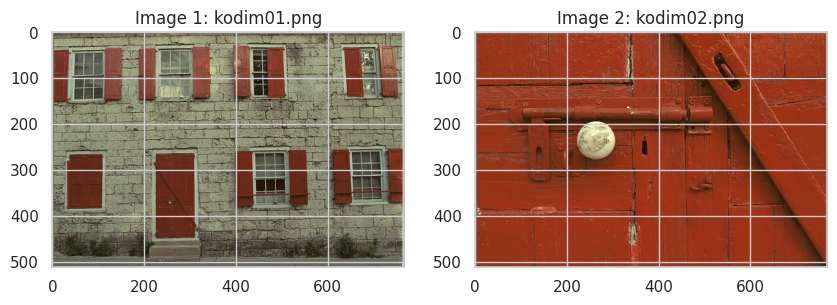

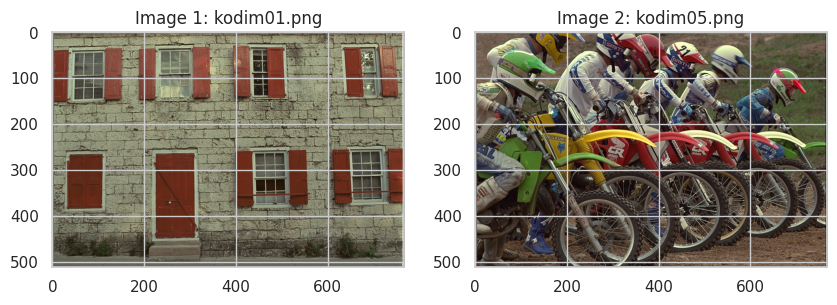

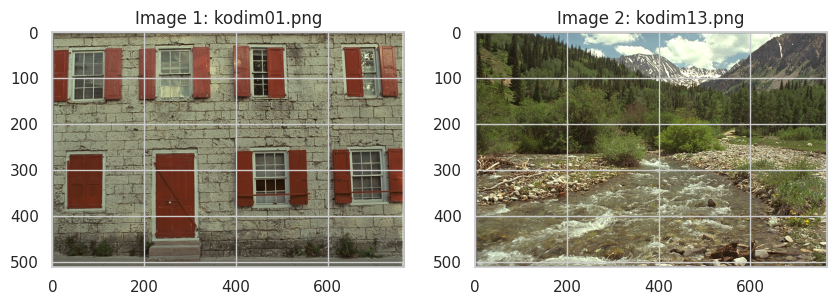

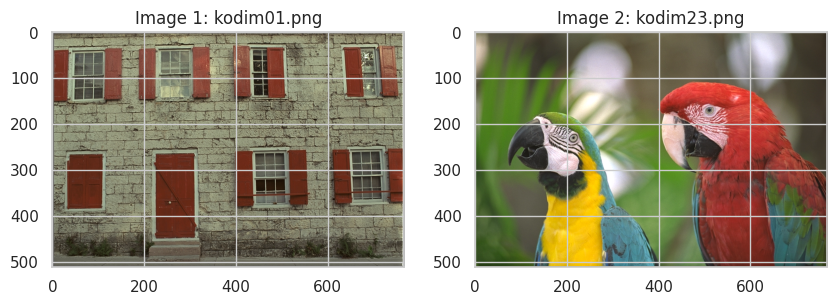

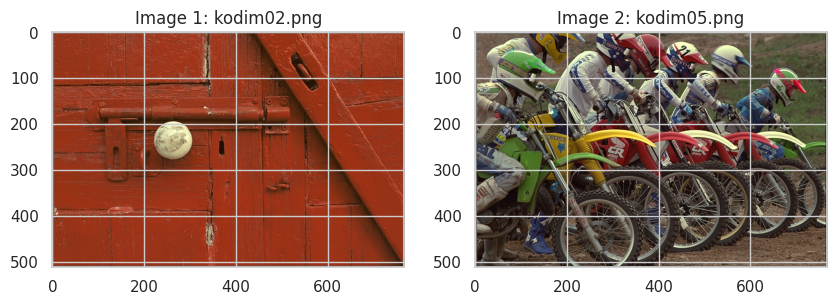

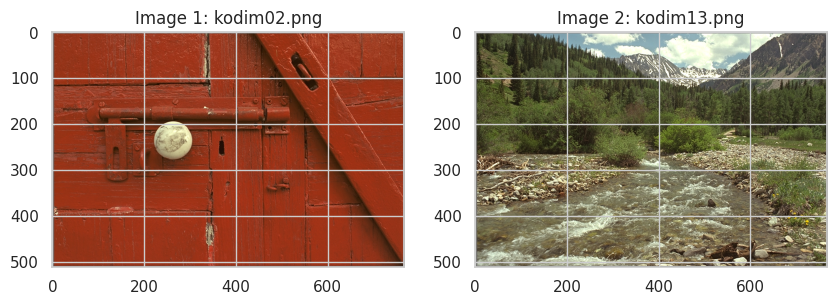

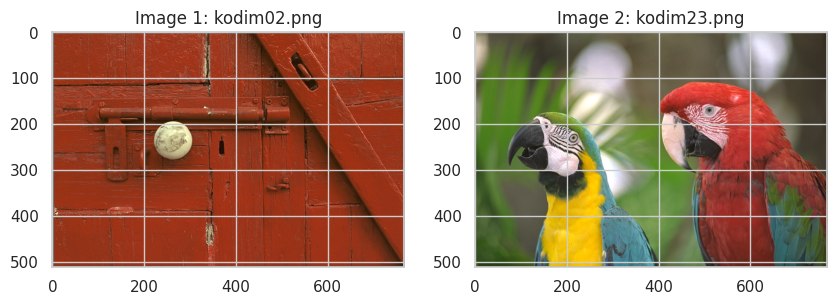

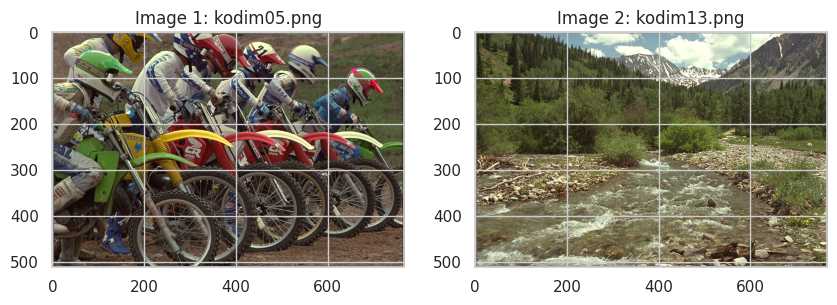

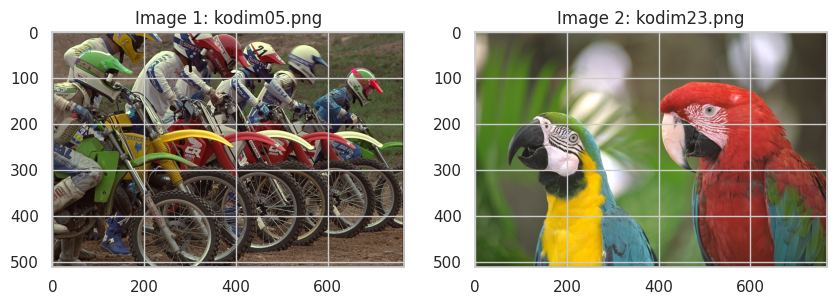

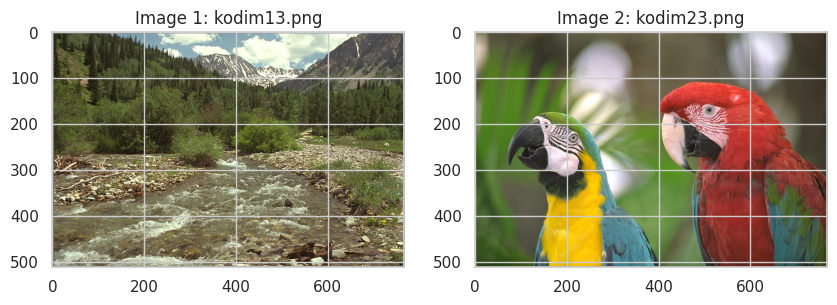

In [146]:
from itertools import combinations

root = "images"
filenames = ["kodim01.png", "kodim02.png", "kodim05.png", "kodim13.png", "kodim23.png"]

# Calculate all unique pairs of images
image_pairs = list(combinations(filenames, 2))

# For each pair, read the images, convert them to RGB, and display them side by side
for (img_file1, img_file2) in image_pairs:
    img1 = cv2.imread(f"{root}/{img_file1}")
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    img2 = cv2.imread(f"{root}/{img_file2}")
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img1)
    ax[0].set_title(f"Image 1: {img_file1}")
    ax[1].imshow(img2)
    ax[1].set_title(f"Image 2: {img_file2}")
    plt.show()

In [147]:
# For each pair, calculate the PSNR and SSIM
for (img_file1, img_file2) in image_pairs:
    img1 = cv2.imread(f"{root}/{img_file1}")
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    img2 = cv2.imread(f"{root}/{img_file2}")
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    psnr_score = psnr(img1, img2)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    ssim_score = ssim(img1_gray, img2_gray)

    print(f"PSNR between {img_file1} and {img_file2}: {psnr_score:.2f}")
    print(f"SSIM between {img_file1} and {img_file2}: {ssim_score:.2f}")
    print("\n")

PSNR between kodim01.png and kodim02.png: 11.86
SSIM between kodim01.png and kodim02.png: 0.19


PSNR between kodim01.png and kodim05.png: 11.71
SSIM between kodim01.png and kodim05.png: 0.08


PSNR between kodim01.png and kodim13.png: 11.22
SSIM between kodim01.png and kodim13.png: 0.07


PSNR between kodim01.png and kodim23.png: 11.85
SSIM between kodim01.png and kodim23.png: 0.19


PSNR between kodim02.png and kodim05.png: 11.73
SSIM between kodim02.png and kodim05.png: 0.17


PSNR between kodim02.png and kodim13.png: 10.64
SSIM between kodim02.png and kodim13.png: 0.13


PSNR between kodim02.png and kodim23.png: 11.12
SSIM between kodim02.png and kodim23.png: 0.44


PSNR between kodim05.png and kodim13.png: 10.44
SSIM between kodim05.png and kodim13.png: 0.07


PSNR between kodim05.png and kodim23.png: 10.71
SSIM between kodim05.png and kodim23.png: 0.17


PSNR between kodim13.png and kodim23.png: 10.47
SSIM between kodim13.png and kodim23.png: 0.14




In [148]:
root = "images"
filenames = ["kodim01.png", "kodim02.png", "kodim05.png", "kodim13.png", "kodim23.png"]
saving_file = "result_2.csv"

if os.path.exists(saving_file):
    os.remove(saving_file)

df = pd.DataFrame(columns=["$image1$", "$image2$", "PSNR", "SSIM", "Compression Rate"])


image_pairs = combinations(filenames, 2)

for file1, file2 in tqdm(image_pairs, total=int(len(filenames)*(len(filenames)-1)/2), desc="Processing image pairs"):
    img1_path = os.path.join(root, file1)
    img2_path = os.path.join(root, file2)
    
    img1 = cv2.imread(img1_path)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    kl_img1, eig_vectors1, eig_values1, means1 = kl_transform(img1)

    img2 = cv2.imread(img2_path)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    tmp_img2 = img2 - means1
    tmp_img2 = tmp_img2.reshape(-1, img2.shape[2])
    kl_img2 = np.dot(tmp_img2, eig_vectors1.T)
    kl_img2 = kl_img2.reshape(img2.shape)
    quantized_kl_img2 = quantify(kl_img2, [8,8,4])
    inv_kl_img2 = inverse_kl_transform(quantized_kl_img2, eig_vectors1, means1)
    inv_kl_img2 = np.clip(inv_kl_img2, 0, 255).astype(np.uint8)

    psnr_score = psnr(img2, inv_kl_img2, data_range=255)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    inv_kl_img2_gray = cv2.cvtColor(inv_kl_img2, cv2.COLOR_RGB2GRAY)
    ssim_score = ssim(img2_gray, inv_kl_img2_gray)

    comp_rate = 1 - get_size(quantized_kl_img2) / get_size(img2)

    new_row = {"$image1$": file1, "$image2$": file2, "PSNR": psnr_score, "SSIM": ssim_score, "Compression Rate": comp_rate}
    new_row_df = pd.DataFrame([new_row])
    df = pd.concat([df, new_row_df], ignore_index=True)

# Save the results to a CSV file
df.to_csv(saving_file, index=False)

Processing image pairs:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_123226/2555066164.py:40: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

Processing image pairs: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


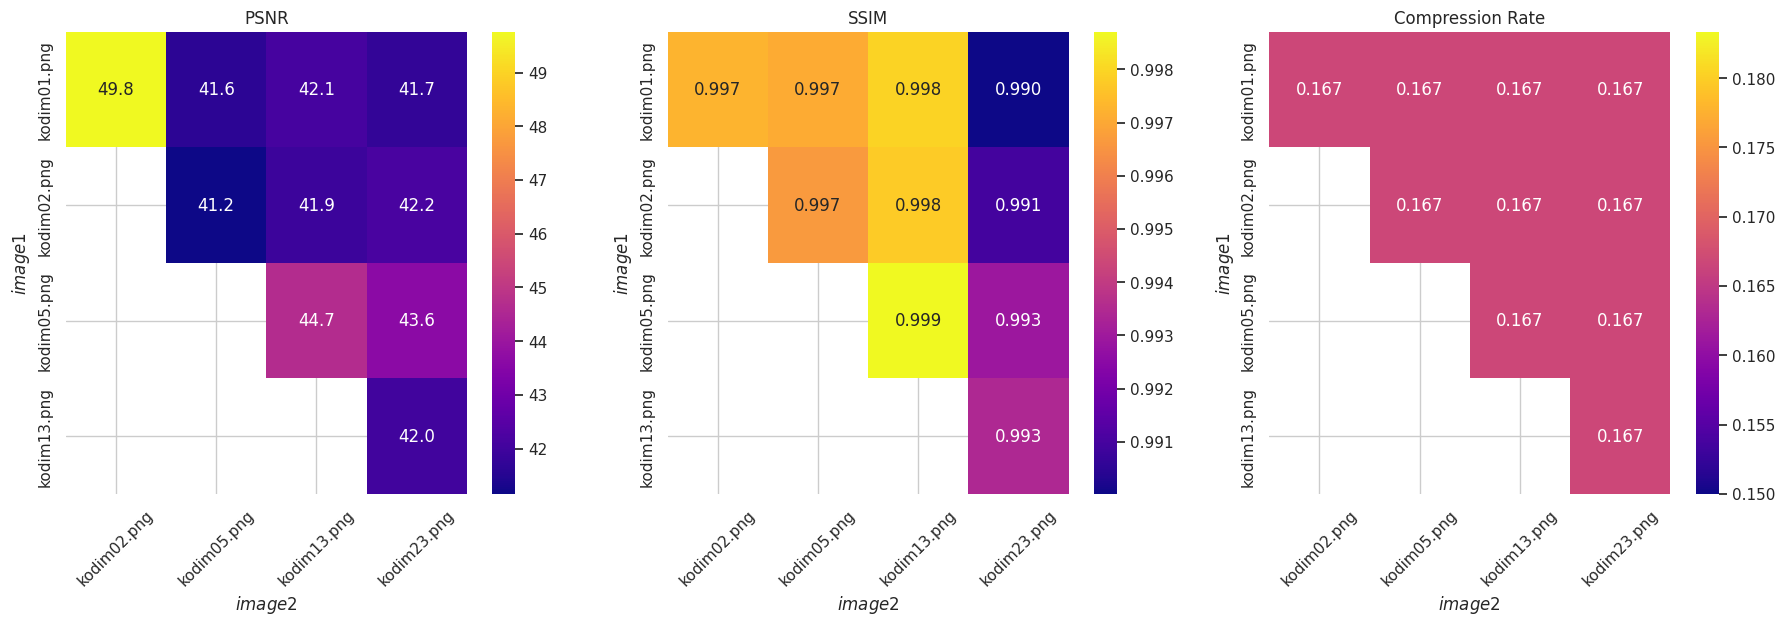

In [149]:
df = pd.read_csv(saving_file)

pivot_table_psnr = df.pivot(index = '$image1$', columns = '$image2$', values = 'PSNR')
pivot_table_ssim = df.pivot(index = '$image1$', columns = '$image2$', values = 'SSIM')
pivot_table_CR = df.pivot(index = '$image1$', columns = '$image2$', values = 'Compression Rate')

fig, ax = plt.subplots(1, 3, figsize = (22, 6))
sns.heatmap(pivot_table_psnr, annot=True, cmap='plasma', fmt=".1f", ax = ax[0])
ax[0].set_title("PSNR")
sns.heatmap(pivot_table_ssim, annot=True, cmap='plasma', fmt=".3f", ax = ax[1])
ax[1].set_title("SSIM")
sns.heatmap(pivot_table_CR, annot=True, cmap='plasma', fmt=".3f", ax = ax[2])
ax[2].set_title("Compression Rate")

for axis in ax:
    axis.set_xticklabels(axis.get_xticklabels(), rotation=45)
    
plt.show()